Connect to drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Check if drive is connected.

In [ ]:
!ls /content/drive/My\ Drive/Master\ Scriptie

Install flair on Google Colab.

In [ ]:
!pip install flair

Import needed settings.

In [6]:
import flair
import numpy as np
from pathlib import Path
from typing import List
from google.colab import files
import random
import torch
import os
import numpy as np
from torch.optim.adam import Adam
from flair.data import Corpus
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.datasets import ClassificationCorpus
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.visual.training_curves import Plotter


Setting random seed.

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

Converting text to dictionary input for flair library. 

Please note that the input must have a specific format in order to be converted.

\_\_label\_\_CLASSNAME1 TAB	TEXT

\_\_label\_\_CLASSNAME2	TAB TEXT

Flair automatically detects binary or multi-class classification.

In [ ]:
# This is the folder in which train, test and dev files reside.



data_folder = '/content/drive/My Drive/Master Scriptie/'


# The BERT texts contains no emojis.
corpus: Corpus = ClassificationCorpus(Path(data_folder), 
                                      test_file='flair_test.txt',
                                      dev_file='flair_dev.txt',
                                      train_file='flair_train.txt')

# Check if output is correct.
#print(corpus.train[0])
#print(corpus.train[0].labels)
#print(corpus.obtain_statistics())

# Create dictionary for input.
label_dict=corpus.make_label_dictionary()


In this section it is possible to define which embeddings should be used.


Different sorts of embeddings can be easily implemented and stacked upon each other.

This can be done by adding word embeddings in the list of variable: word_embeddings.

After this the embeddings can be loaded and you can choose what kind of neural network and parameters you wants to use. 

For more information please follow the following link:

https://github.com/flairNLP/flair/blob/master/flair/embeddings/document.py


In [9]:
# embedding = TransformerWordEmbeddings('bert-base-cased')
# embedding = TransformerWordEmbeddings('roberta-base')
# embedding = TransformerWordEmbeddings('xlm-roberta-base', fine_tune=True)
# embedding = TransformerWordEmbeddings('novinsh/xlm-roberta-large-toxicomments-12k', fine_tune=True)
# embedding = WordEmbeddings('glove')


embedding = TransformerWordEmbeddings('wietsedv/bert-base-dutch-cased')
# 3. make a list of word embeddings
word_embeddings = [embedding

                  # FlairEmbeddings('news-forward'),
                  # FlairEmbeddings('news-backward'),
                  # FlairEmbeddings('nl-forward'),
                  # FlairEmbeddings('nl-backward'),
                  ]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                   #hidden_size=256,
                                                                   #reproject_words=True,
                                                                   #reproject_words_dimension=256,
                                                                   rnn_type='LSTM',
                                                                   #rnn_layers=1,
                                                                   bidirectional=True
                                                                   )

In this part a TextClassifier is initialized and the document embeddings and corpus dictionary are given as parameters.

After this a ModelTrainer is initialized.

The ModelTrainer can be given specific parameters to fine-tune the model.

It also saves the model and graphs in a pre-defined folder.

In [ ]:

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)


#trainer.eval()
# 7. start the training

trainer.train('/content/drive/My Drive/Master Scriptie/results/testing_model',
              learning_rate=0.001,
              mini_batch_size=32,
              max_epochs=10,
              checkpoint=True,
              save_final_model=True,
              train_with_dev=False,
              param_selection_mode=False,
              embeddings_storage_mode='gpu',
              )

In [53]:

import os
import sklearn.metrics as metrics
from flair.data import Sentence
from flair.models import TextClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# You can change the path to use different models.
classifier = TextClassifier.load("/content/drive/My Drive/Master Scriptie/results/BERT-fine-tuning-test-10epoch/best-model.pt")

true = 0
false = 0
c = 0
Y_test = []
predictions = []

with open('/content/drive/My Drive/Master Scriptie/MISC_sentences_100_gold_standard_union.txt', 'r') as file:
      for line in file.readlines():
          line = line.strip()
          line = line.split('\t')
          if len(line) > 0:
              if line[0] == 'SENTENCE:':
                  sentence = Sentence(line[1])
                  classifier.predict(sentence, multi_class_prob=True)
                  prediction = sentence.labels
                  prediction = [p for p in prediction if p.score > 0.5]

                  # prediction_scores = [i.score for i in prediction]
                  prediction_labels = [i.value for i in prediction]

              elif line[0] == 'ENTITY:':
                  entity = line[1]
              
              elif line[0] == 'ANSWER:':
                  
                  if len(line) > 1:
                      c += 1
                      answer = line[1:]
                      Y_test.append(answer)

                      predictions.append(prediction_labels)
                      intersect = list(set(answer) & set(prediction_labels))

                      # Use this code to calculate baseline.
                      # baseline = ['Category:Humanities']
                      # predictions.append(baseline)
                      # intersect = list(set(baseline) & set(answer))

                      if len(intersect) > 0:
                          true += 1
                      else:
                          false += 1

m = MultiLabelBinarizer().fit(Y_test)

Y_test = m.transform(Y_test)
predictions = m.transform(predictions)

print('RECALL MICRO: ', metrics.recall_score(y_true=Y_test, y_pred=predictions, average='micro', zero_division=1))
print('PRECISION MICRO: ', metrics.precision_score(y_true=Y_test, y_pred=predictions, average='micro', zero_division=1))
print('F1-SCORE MICRO: ', metrics.f1_score(y_true=Y_test, y_pred=predictions, average='micro', zero_division=1))

print('\n\n')
print('RECALL MACRO: ', metrics.recall_score(y_true=Y_test, y_pred=predictions, average='macro', zero_division=1))
print('PRECISION MACRO: ', metrics.precision_score(y_true=Y_test, y_pred=predictions, average='macro', zero_division=1))
print('F1-SCORE MACRO: ', metrics.f1_score(y_true=Y_test, y_pred=predictions, average='macro', zero_division=1))


print('TOTAL: ', c)
print('CORRECT: ', true)
print('FALSE: ', false)

print('ACCURACY: ', true/(true + false))



2020-08-05 12:41:08,562 loading file /content/drive/My Drive/Master Scriptie/results/BERT-fine-tuning-test-10epoch/best-model.pt
RECALL MICRO:  0.028985507246376812
PRECISION MICRO:  0.08
F1-SCORE MICRO:  0.0425531914893617



RECALL MACRO:  0.024390243902439025
PRECISION MACRO:  0.9775609756097561
F1-SCORE MACRO:  0.0036133694670280035
TOTAL:  100
CORRECT:  8
FALSE:  92
ACCURACY:  0.08


Below the code can be found to visualize the learning rate, loss and weights. 

With this information one can easily fine-tune the system.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[1.4454397707459274e-07]
[1.7378008287493754e-07]
[2.0892961308540395e-07]
[2.51188643150958e-07]
[3.019951720402016e-07]
[3.6307805477010137e-07]
[4.36515832240166e-07]
[5.248074602497725e-07]
[6.309573444801933e-07]
[7.585775750291837e-07]
[9.120108393559096e-07]
[1.096478196143185e-06]
[1.3182567385564074e-06]
[1.5848931924611132e-06]
[1.9054607179632473e-06]
[2.2908676527677735e-06]
[2.754228703338166e-06]
[3.311311214825911e-06]
[3.981071705534973e-06]
[4.7863009232263826e-06]
[5.754399373371569e-06]
[6.918309709189365e-06]
[8.317637711026708e-06]
[9.999999999999999e-06]
[1.202264434617413e-05]
[1.4454397707459279e-05]
[1.737800828749376e-05]
[2.0892961308540385e-05]
[2.5118864315095795e-05]
[3.019951720402016e-05]
[3.630780547701014e-05]
[4.365158322401661e-05]
[5.248074602497728e-05]
[6.309573444801929e-05]
[7.585775750291836e-05]
[9.120108393559096e-05]
[0.00010964781961431851]
[0.00013182567385564074]
[0.0001584893192461114]
[0.00019054607179632462]
[0.00022908676527677726]
[0

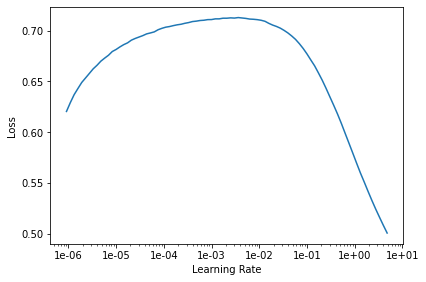

2020-08-03 18:12:38,805 ----------------------------------------------------------------------------------------------------
2020-08-03 18:12:38,806 WARNING: No LOSS found for test split in this data.
2020-08-03 18:12:38,807 Are you sure you want to plot LOSS and not another value?
2020-08-03 18:12:38,808 ----------------------------------------------------------------------------------------------------
2020-08-03 18:12:38,829 ----------------------------------------------------------------------------------------------------
2020-08-03 18:12:38,830 WARNING: No F1 found for test split in this data.
2020-08-03 18:12:38,830 Are you sure you want to plot F1 and not another value?
2020-08-03 18:12:38,831 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in /content/drive/My Drive/Master Scriptie/results/GloVe-fine-tuning-test-10epoch/training.png


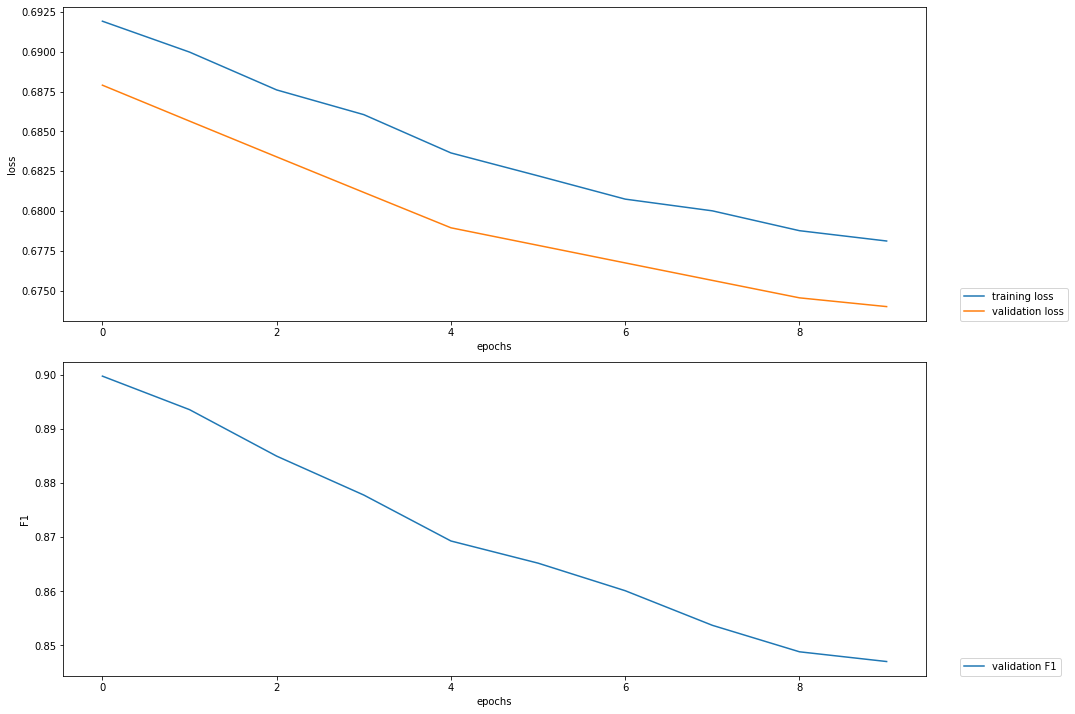

Weights plots are saved in /content/drive/My Drive/Master Scriptie/results/GloVe-fine-tuning-test-10epoch/weights.png


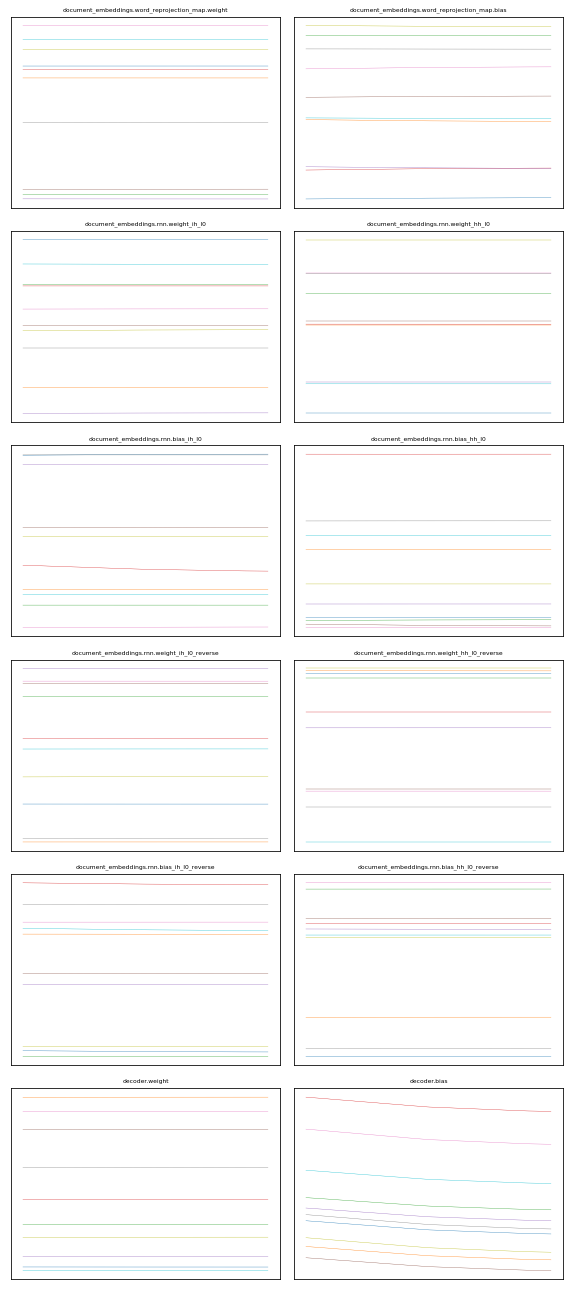

In [ ]:
# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)#, multi_label=True)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)#, optimizer=Adam)
#trainer.seed_torch(0)

# 8. find learning rate
plotter = Plotter()
learning_rate_tsv = trainer.find_learning_rate('/content/drive/My Drive/Master Scriptie/results/GloVe-fine-tuning-test-10epoch/','learning_rate.tsv')
plotter.plot_learning_rate(learning_rate_tsv)

# 9. plot weight traces (optional)
plotter.plot_training_curves('/content/drive/My Drive/Master Scriptie/results/GloVe-fine-tuning-test-10epoch/loss.tsv')
plotter.plot_weights('/content/drive/My Drive/Master Scriptie/results/GloVe-fine-tuning-test-10epoch/weights.txt')